In [3]:
from MElCorr import MElCorrCpp as melcpp
import MElCorr.MElCorrPy as melpy
import numpy as np
import matplotlib.pyplot as plt
import camb
import scipy
from tqdm.notebook import tqdm
from GaussianCovariance import *
from scipy.special import legendre


In [4]:
k_bins=np.load('npy_pk/k_bins.npy')

In [5]:
k_bins

array([0.01570796, 0.02356194, 0.03141593, 0.03926991, 0.04712389,
       0.05497787, 0.06283185, 0.07068583, 0.07853982, 0.0863938 ,
       0.09424778, 0.10210176, 0.10995574, 0.11780972, 0.12566371,
       0.13351769, 0.14137167, 0.14922565])

In [6]:
eh = melpy.EisensteinHu()

In [7]:
omb_fid = 0.048
h_fid = 0.676
omc_fid = 0.31 - omb_fid
sigma8_fid = 0.824

In [8]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h_fid, ombh2=omb_fid*h_fid**2, omch2=omc_fid*h_fid**2)
pars.set_matter_power(redshifts=[0.], kmax=2.0)
results = camb.get_results(pars)
sigma8=camb.get_results(pars).get_sigma8()
pars.InitPower.set_params(As=2e-9*sigma8_fid**2/sigma8**2, ns=0.965)
pars.set_matter_power(redshifts=[0.38], kmax=2.0)
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 200)

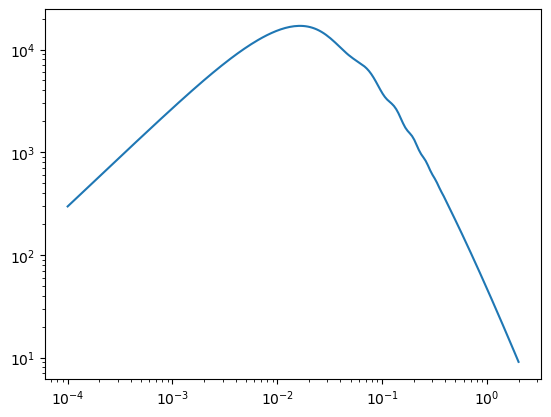

In [9]:
plt.loglog(kh, pk[0])

In [10]:
eh.set_params(omega_m=omb_fid + omc_fid, omega_b=omb_fid, h=h_fid, ns=0.965, sigma8=results.get_sigma8()[0], T_CMB=2.725)

In [11]:
pk_nw = eh.power_spectrum(kh)

In [12]:
eh.set_params(omega_m=omb_fid + omc_fid, omega_b=omb_fid, h=h_fid, ns=0.965, sigma8=results.get_sigma8()[0], T_CMB=2.725)

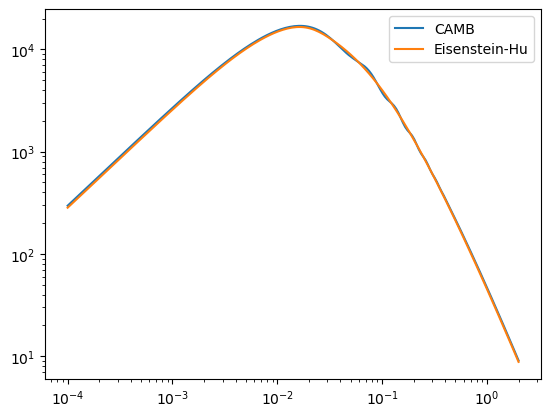

In [13]:
plt.plot(kh, pk[0], label='CAMB')
plt.plot(kh, pk_nw, label='Eisenstein-Hu')
plt.xscale('log')
plt.yscale('log')
plt.legend()


In [14]:
P_nw = scipy.interpolate.interp1d(kh, pk_nw, kind='cubic', fill_value='extrapolate')

In [15]:
Sigma = melpy.utilities.compute_sigma2(P_nw)

In [16]:
damp = (1 + kh**2*Sigma)*np.exp(-kh**2*Sigma)

In [17]:
pk_dw = pk_nw + damp*(pk[0] - pk_nw)

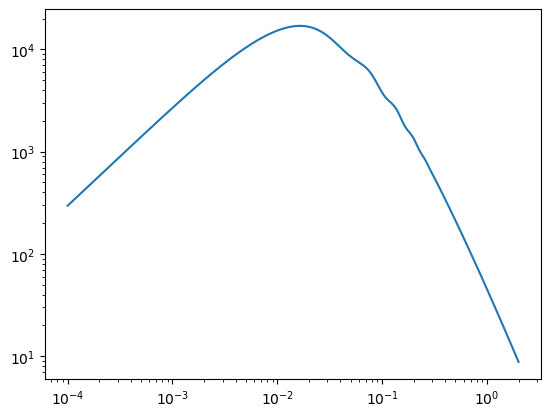

In [18]:
plt.loglog(kh, pk_dw)

In [19]:
pk_dw = scipy.interpolate.interp1d(kh, pk_dw, kind='cubic', fill_value='extrapolate')

In [20]:
results.get_fsigma8()/results.get_sigma8()

array([0.71587359])

In [21]:
f = 0.71

In [22]:
deg = 51

mu, weights = np.polynomial.legendre.leggauss(deg)

In [23]:
b1 = 2.0
sigma_v = 3

p_k_mu = lambda k, mu: (b1 + f*mu**2)**2*pk_dw(k)*np.exp(-f*k**2*mu**2*sigma_v**2)

In [24]:
def p_l(l_list, kk):
    p_k_l ={}
    for ll in l_list:
        leg = legendre(ll)(mu)
        p_k_l[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu(k, mu) * leg)  for k in kk]) 
    return p_k_l

In [25]:
l_list = [0,2,4,6]

In [26]:
P_model = p_l(l_list, kh)

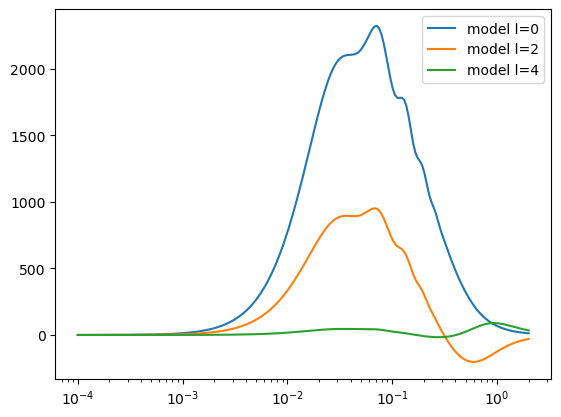

In [27]:
plt.semilogx(kh, kh * P_model[0], label='model l=0')
plt.semilogx(kh,  kh * P_model[2], label='model l=2')
#plt.semilogx(kh,  kh * b1**2*pk[0], label='camb')
plt.semilogx(kh,  kh * P_model[4], label='model l=4')

plt.legend()

In [28]:
import hankl


In [29]:
s, xi0 = hankl.P2xi(kh, P_model[0]*np.exp(-kh**2), l=0)
_, xi2 = hankl.P2xi(kh, P_model[2]*np.exp(-kh**2), l=2)

/home/cla_guida/anaconda3/envs/mc-env/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cla_guida/anaconda3/envs/mc-env/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


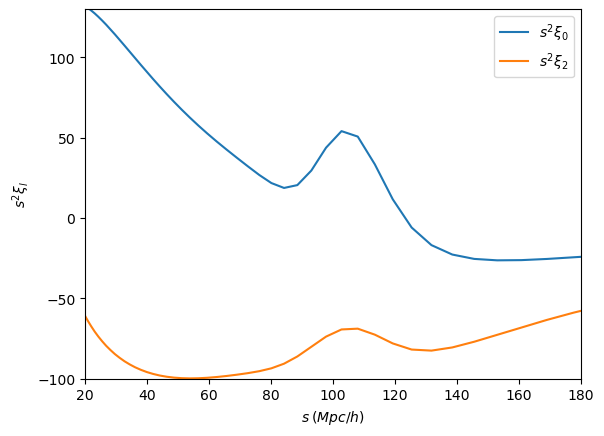

In [30]:
plt.plot(s, s*s*xi0, label=r'$s^{2}\xi_{0}$')
plt.plot(s, s*s*xi2, label=r'$s^{2}\xi_{2}$')
plt.xlim(20,180)
plt.ylim(-100,130)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.legend()
plt.show()

In [31]:
#inverse trasformation
k, P0_inv  = hankl.xi2P(s, xi0,l=0)
k, P2_inv = hankl.xi2P(s,xi2,l=2)

/home/cla_guida/anaconda3/envs/mc-env/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


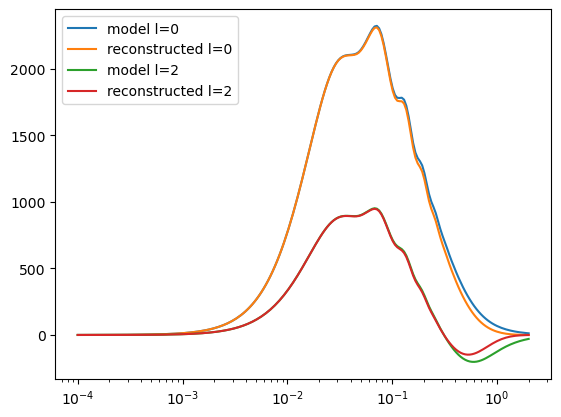

In [32]:
plt.semilogx(kh, kh * P_model[0], label='model l=0')
plt.semilogx(k, k * P0_inv, label='reconstructed l=0')
plt.semilogx(kh,  kh * P_model[2], label='model l=2')
plt.semilogx(k, k * P2_inv, label='reconstructed l=2')
plt.legend()

# Obtaining multipoles window function with pair counting approach

In [63]:
rr = np.load('rr') #I take it from Elisa measure, itis up to 200 

In [64]:
rr.shape

(800,)

By first applying a $(2q+1)L_q(\mu)/2$ weighting to each pair

In [65]:
rr_q = {}
for q in l_list:
    leg = legendre(q)(mu)
    rr_q[q] = 0.5 * (2*q+1) * np.array([np.sum(weights * r * leg)  for r in rr]) 

In [66]:
rr_q[2].shape

(800,)

$\bar{RR}^{tot}_q = 1/2 \bar n_s^2 2\pi\Delta^3d(ln\Delta)Q_q(\Delta)$  I have to find $Q_q(\Delta)$

In [67]:
ns = 3e-4

In [68]:
r_bins = np.linspace(0,200,800)

In [69]:
Q = np.zeros((len(r), len(l_list)))
for i, r in enumerate(rr):
    for j, q in enumerate(l_list):
        Q[i,j] = rr_q[q][i]/(np.pi*ns**2*r_bins[i]**2)

/tmp/ipykernel_35700/1370227286.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  Q[i,j] = rr_q[q][i]/(np.pi*ns**2*r_bins[i]**2)


In [70]:
Q.shape

(800, 4)

In [71]:
#I have to enforce Q0(0) = 1.
Q[0,0] = 1

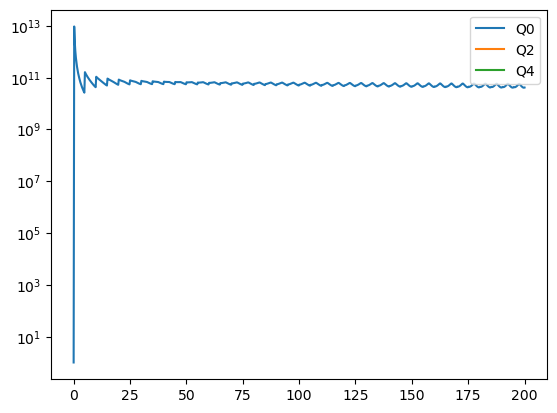

In [77]:
plt.plot(r_bins, Q[:,0], label='Q0')
plt.plot(r_bins, Q[:,1], label='Q2')
plt.plot(r_bins, Q[:,2], label='Q4')
plt.yscale('log')
plt.legend()

In [140]:
filename = 'public_material_RSD/Beutleretal_window_z1_SGC.dat'

In [141]:
data = np.loadtxt(filename, skiprows=1)

In [142]:
sep = data[:,0]
rr0 = data[:,1]
rr2 = data[:,2]
rr4 = data[:,3]
rr6 = data[:,4]
rr8 = data[:,5]

In [143]:
#I have to find Q0, Q2, Q4, Q6, Q8  

In [144]:
l_list = [0,2,4,6,8]

In [145]:
rrr = np.array([rr0, rr2, rr4, rr6, rr8])

In [146]:
rr.shape

(5, 5000)

In [148]:
Q_q = {}
for i, q in enumerate(l_list):
    Q_q[q] = rrr[i]/(np.pi*ns**2*sep**2)

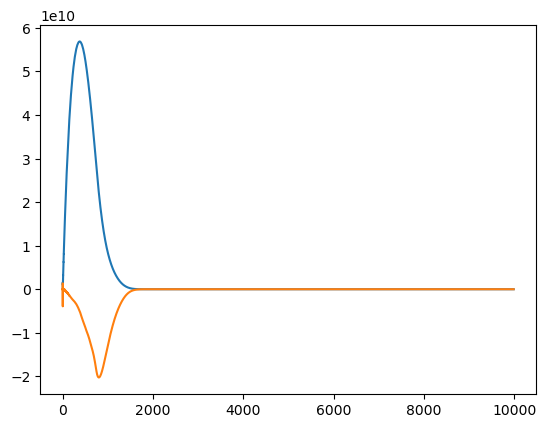

In [154]:
#plt.plot(sep, Q_q[0], label='Q0')
plt.plot(sep, Q_q[2], label='Q2')
plt.plot(sep, Q_q[4], label='Q4')

In [100]:
sep = np.load('r.npy')
rr = np.load('rr.npy') 

In [102]:
rr_q = {}
for q in l_list:
    leg = legendre(q)(mu)
    rr_q[q] = 0.5 * (2*q+1) * np.array([np.sum(weights * r * leg)  for r in rr]) 

In [105]:
Q_q = {}
for q in l_list:
    Q_q[q] = rr_q[q]/(np.pi*ns**2*sep**2)

In [107]:
Q_q[0].shape

(800,)

In [111]:
#renoormalize Q0
Q_q[0][0] = 1

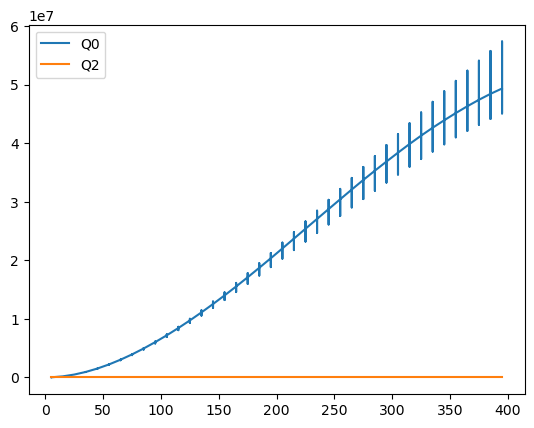

In [113]:
plt.plot(sep, rr_q[0], label='Q0')
plt.plot(sep, rr_q[2], label='Q2')
plt.legend()